# Supernovae Regression

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee as mc
import scipy.stats as sp
import corner
import dynesty

from astroML.datasets import generate_mu_z
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
from scipy.integrate import quad
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from astropy.cosmology import LambdaCDM
from astropy.cosmology import WMAP9 as cosmo
from sklearn.utils import shuffle

/Users/federicofantoccoli/anaconda3/lib/python3.12/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_57063/910475193.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


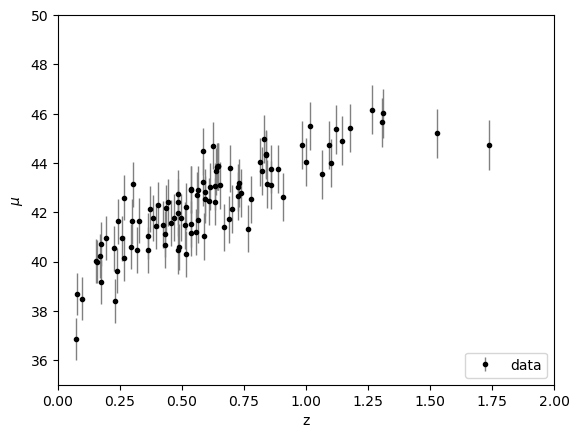

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state = 1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## True model

True model implementatio by astropy

In [3]:
def Cosmo_model (z, Omega_mo, Ho):
    
    cosmology = LambdaCDM (H0 = Ho, Om0 = Omega_mo, Ode0 = (1 - Omega_mo))
    
    return cosmology.distmod(z).value

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_57063/1591713546.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")
/Users/federicofantoccoli/anaconda3/lib/python3.12/site-packages/astropy/cosmology/flrw/base.py:1351: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


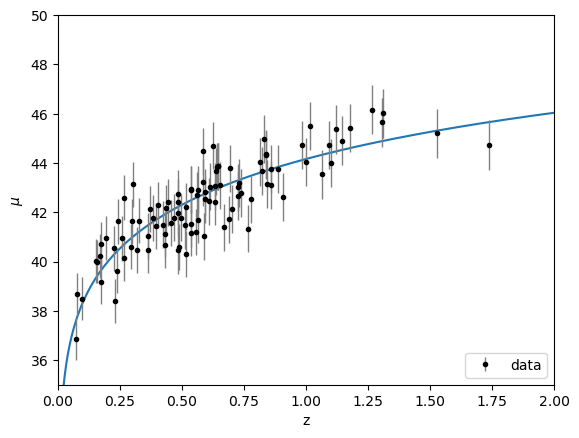

In [4]:
z_grid = np.linspace(0, 2, 300)


plt.plot(z_grid, Cosmo_model(z_grid, 0.27, cosmo.H(0).value))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## GPR

Intuitively, what GPR does is to generate a lot of functions from gaussian basis that cross the points (including the error contributions), than it draws the best fit which is an average of all the fitting functions

In [5]:
z_sample_s, mu_sample_s, dmu_s = shuffle(z_sample, mu_sample, dmu, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(z_sample_s, mu_sample_s, test_size=0.2, random_state=42, shuffle = False)

dmu_train = dmu_s[:80]
dmu_test = dmu_s[80:]

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_57063/4127291973.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(z_grid, y_mean - y_std, y_mean + y_std, color='gray', alpha=0.3, label = '1 $\sigma$')
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_57063/4127291973.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(z_grid, y_mean - 2*y_std, y_mean + 2*y_std, color='darkcyan', alpha=0.3, label = '2 $\sigma$')
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_57063/4127291973.py:17: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')


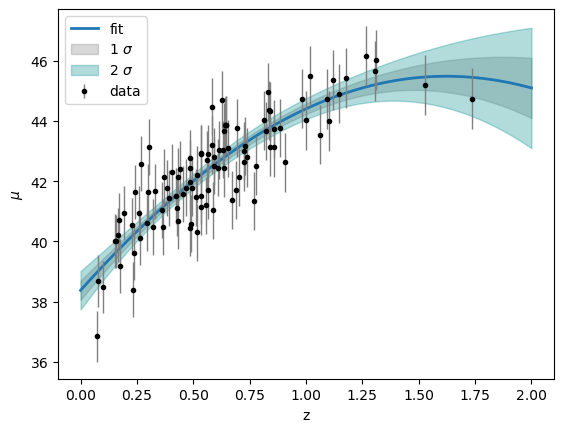

In [6]:
# Alpha is regularisation:
#Value added to the diagonal of the kernel matrix during fitting. 
#This can prevent a potential numerical issue during fitting, by ensuring 
#that the calculated values form a positive definite matrix. It can also be interpreted 
#as the variance of additional Gaussian measurement noise on the training observations.

# RBF is the Radial Basis Function kernel. / is the lenght scale (width) of the kernel

kernel = kernels.ConstantKernel(1.0) * kernels.RBF(7.0)
GPR = GaussianProcessRegressor(kernel = kernel, alpha = dmu_train**2)
GPR.fit(x_train[:, np.newaxis], y_train[:, np.newaxis])
means, stds = GPR.predict(x_test[:, np.newaxis], return_std = True)
# print(means)

z_grid = np.linspace(0, 2, 300)
y_mean, y_std = GPR.predict(z_grid[:, np.newaxis], return_std = True)
# print(y_std)

fig = plt.figure()
plt.plot(z_grid, y_mean, lw = 2, label = 'fit')
plt.fill_between(z_grid, y_mean - y_std, y_mean + y_std, color='gray', alpha=0.3, label = '1 $\sigma$')
plt.fill_between(z_grid, y_mean - 2*y_std, y_mean + 2*y_std, color='darkcyan', alpha=0.3, label = '2 $\sigma$')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

Try to predict some supernovae with the data driven model

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_57063/3696385847.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')
/Users/federicofantoccoli/anaconda3/lib/python3.12/site-packages/astropy/cosmology/flrw/base.py:1351: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


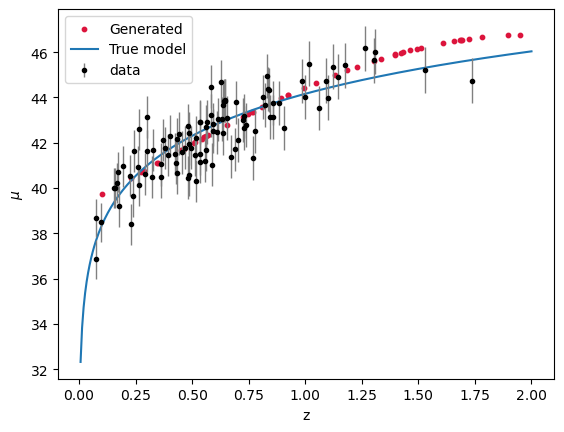

In [7]:
new_z = np.random.uniform(0.1, 2, 50)
new_mu = GPR.sample_y(new_z[:, np.newaxis])

fig = plt.figure()
plt.scatter(new_z, new_mu, color = 'crimson', marker = 'o', label = 'Generated', s = 10)
plt.plot(z_grid, Cosmo_model(z_grid, 0.27, cosmo.H(0).value), label = 'True model')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

The model fitted seems quite similar to the true one, the last part is difficult because there aren't so many events there and also the errorbars are large

## MCMC

Here I try to fit for the parameters using a MCMC algorithm

In [8]:
# Supernovae cosmology

c = 0.97e-8 # pc / s
Ho_min = 60
Ho_max = 80
Omega_max = 1
Omega_min = 0

# Fitting model
def Dist_modulus (z, Omega_mo, Ho):
    
    dist_modulus = np.zeros(len(z))
    
    for i in range(len(z)):
        dist_modulus[i] = 5 * np.log10((c / (10 * Ho)) * (1 + z[i]) * quad( lambda x: 1/ (Omega_mo * (1 + x)**3 + 1-Omega_mo)**0.5, 0, z[i])[0])
    
    return dist_modulus

def Cosmo_model (z, Omega_mo, Ho):
    
    cosmology = LambdaCDM (H0 = Ho, Om0 = Omega_mo, Ode0 = (1 - Omega_mo))
    
    return cosmology.distmod(z).value

# Priors chosen to be not too wide (smaller than Riess et al. 1998)
def Ho_prior (param):
    
    Ho, Omega_mo = param
    
    if Ho_min <= Ho <= Ho_max:
        return 1/(Ho_max - Ho_min)
    return 0  

def Omega_mo_prior (param):
    
    Ho, Omega_mo = param
    
    if Omega_min <= Omega_mo <= Omega_max:
        return 1/(Omega_max - Omega_min)
    return 0

# Total log prior
def log_prior (param):
    
    Ho, Omega_mo = param
    
    if Ho_min < Ho < Ho_max and Omega_min < Omega_mo < Omega_max:
        return 0.0
    
    return -np.inf


# Assuming a normal distribution for the uncertanties on mu (as Riess et al. - 1998 does)
# I can write the loglikelihood function and the posterior:
    
def loglikelihood (param, z, mu, sigma_mu):
         
        Ho, Omega_mo = param
            
        # Here I need to check the value of Omega_mo as in the priors,
        # If I use the cosmological model already implemented Omega_mo should
        # not be negative!
        # just not to make errors appear, the prior will give me the same selection
        
        if Omega_mo < 0:
            return -np.inf
        
        # Here I can take directly the log: less computations
        
        # Here I'm trying with the Astropy implementation:
        log_L_i = (mu - Cosmo_model(z, Omega_mo, Ho))**2 / (sigma_mu**2)
        return -0.5 * np.sum(log_L_i) 

def Log_Posterior (param, z, mu, sigma_mu):
    
    # log_prior = np.log( Ho_prior(param) * Omega_mo_prior(param) )
    
    # if not np.isfinite(log_prior):
    #     return -np.inf
   
    return loglikelihood(param, z, mu, sigma_mu) + log_prior(param)

In [9]:
ndim = 2  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 20000  # number of MCMC steps to take **for each walker**

# initialize theta (parameters guesses, by eye from dataset + perturbation) 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim)) + [70, 0.5]

# call the MCMC method and run it!
MC_sampler = mc.EnsembleSampler(nwalkers, ndim, Log_Posterior, args = (z_sample, mu_sample, dmu))
MC_sampler.run_mcmc(starting_guesses, nsteps, progress = True)

# Here I get the autocorrelation time
tau = MC_sampler.get_autocorr_time()
print('Autocorrelation time for each parameter: ', tau)

# Here the acceptance factor, it's around 50% for each walker,
# it's quite high, maybe beacuse I selected initial conditions not too far
# from the maximum of the posterior?
acceptance_fraction = MC_sampler.acceptance_fraction
print('Mean accepatance fraction: ', np.mean(acceptance_fraction))

# This is the same as .chain (professor's notes)  
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points, take into account the autocorr. time
# I take the maximum of the autoc. time because I want to be sure that
# the samples for each parameter are uncorrelated

samples = MC_sampler.get_chain(flat=True, thin = int(np.max(tau)), discard = burn)


  0%|                                                 | 0/20000 [00:00<?, ?it/s]/Users/federicofantoccoli/anaconda3/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████| 20000/20000 [00:43<00:00, 455.86it/s]

Autocorrelation time for each parameter:  [39.46577647 42.71865651]
Mean accepatance fraction:  0.6851437499999999


<>:3: SyntaxWarning: invalid escape sequence '\O'
<>:3: SyntaxWarning: invalid escape sequence '\O'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_57063/4278274667.py:3: SyntaxWarning: invalid escape sequence '\O'
  labels = ['Ho','$\Omega_M$']


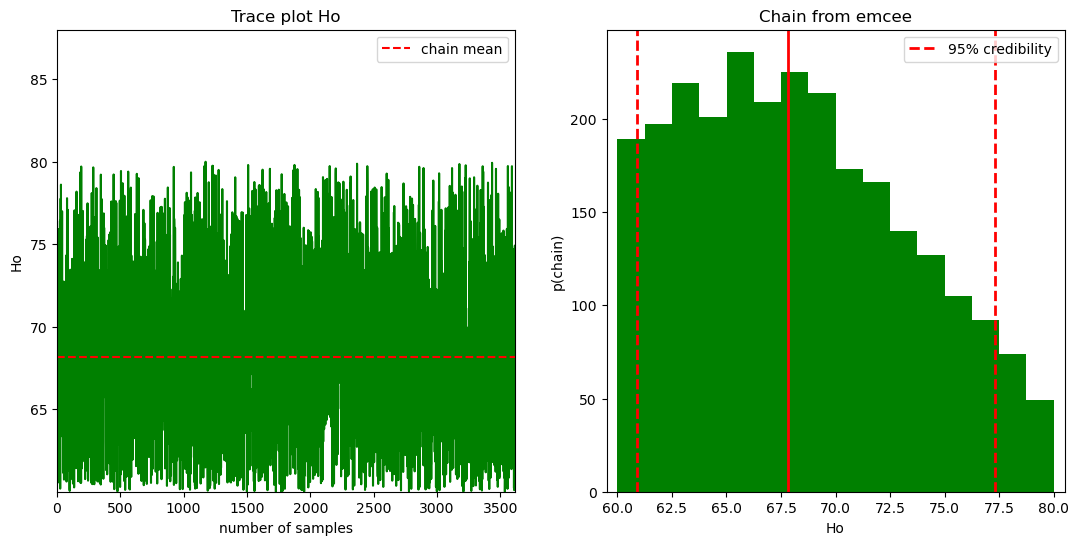

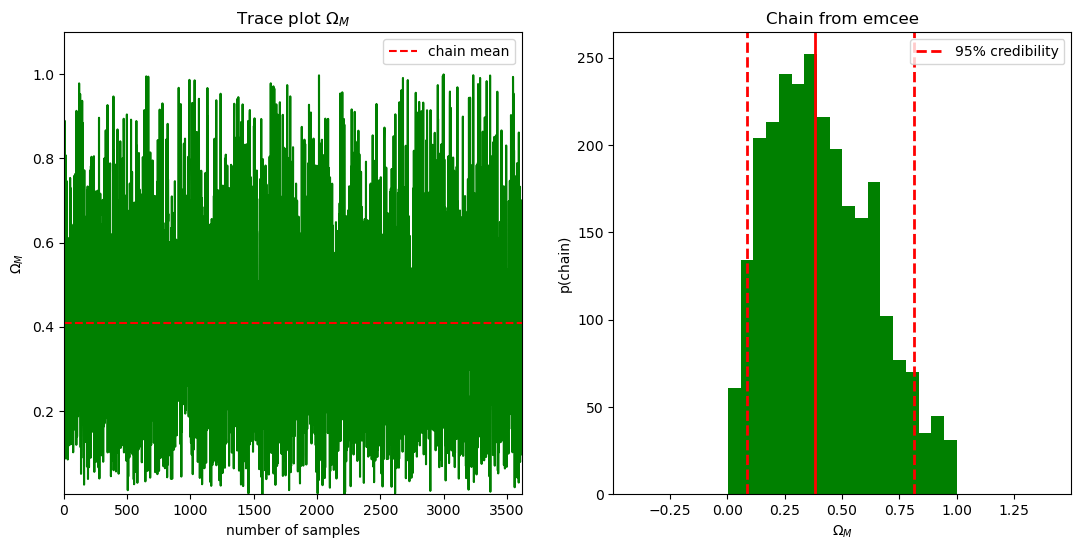

In [10]:
# Diagnostics

labels = ['Ho','$\Omega_M$']

def Trace_plot (parameter_number, trace, data):
    
    fig = plt.figure(figsize=(13, 6))
    
    chain = trace[:,parameter_number]
    M = np.size(chain)
    
    ax1 = fig.add_subplot(121)
    xgrid = np.linspace(1, M, M)
    plt.plot(xgrid, chain, c = 'green')
    ax1.axis([0, M, np.min(chain), 1.1 * np.max(chain)])
    plt.xlabel('number of samples')
    plt.ylabel(labels[parameter_number])
    
    chain_mean = np.mean(chain)
    ax1.axhline(chain_mean, c = 'red', label = 'chain mean', ls = '--') 
    ax1.legend()
    ax1.set_title('Trace plot ' + str(labels[parameter_number]))
    
    ax2 = fig.add_subplot(122)
    # skip first burn samples
    Nburn = 1000
    Nchain = np.size(chain[xgrid > burn])
    Nhist, bins, patches = plt.hist(chain[xgrid > Nburn], bins='scott', histtype='stepfilled', color = 'green')
    
    ax2.set_ylabel('p(chain)')
    ax2.set_xlabel(labels[parameter_number])
    ax2.set_xlim(np.min(chain[burn:]) - 0.5, np.max(chain[burn:]) + 0.5)
    ax2.axvline(np.quantile(chain[xgrid > burn], 0.5), c = 'r', lw = 2)
    ax2.axvline(np.quantile(chain[xgrid > burn], 0.05), ls = '--', c = 'r', lw = 2)
    ax2.axvline(np.quantile(chain[xgrid > burn], 0.95), ls = '--', c = 'r', lw = 2, label = '95% credibility')
    ax2.legend()
    ax2.set_title(r'Chain from emcee')

    return 

Trace_plot(0, samples, z_sample) # Trace_plot and histo for H0
Trace_plot(1, samples, z_sample) # Trace_plot and histo for Omega_m0

Here there is the corner plot from MCMC; it's nice to notice the anticorrelation of the two parameters. The value of Omega_m is bad, but I can look at the plots of some combinations of the parameters to see how they are distributed on the dataset


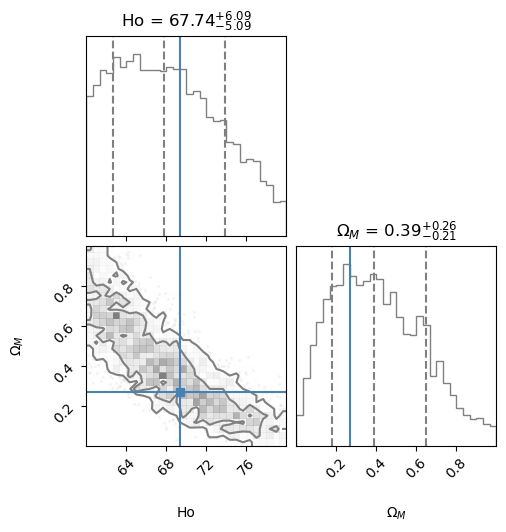

In [11]:
figure = corner.corner(samples, bins = 30, color = 'grey',
            labels = labels, 
            quantiles = [0.16, 0.5, 0.84],
            truths = [cosmo.H(0).value, 0.27],
            levels = [0.68, 0.95], 
            show_titles = True, 
            title_kwargs={"fontsize": 12})

plt.show()

Now I plot some resume stats: the medians, and the means for the parameters.


The 'best model parameters' are the ones at the top of the posterior. From MCMC I get the log posterior and then I find the maximum 

In [12]:
medians = np.array([np.median(samples[:,i])for i in range(ndim)])
means = np.array([np.average(samples[:,i])for i in range(ndim)])

print('Ho Median: %.02f' %medians[0])
print('Ho Means: %.02f' %means[0])
print('Omega_M Median: %.02f' %medians[1])
print('Omega_M Means: %.02f' %means[1], '\n')

log_posterior_mcmc = MC_sampler.get_log_prob(discard = burn, thin = int(np.max(tau)), flat = True)
#print(np.shape(log_posterior_mcmc))

max_post_index = np.argmax(log_posterior_mcmc)
max_post_mcmc = samples[max_post_index]

print('Best Ho: %.02f' %max_post_mcmc[0])
print('Best Omega_M: %.02f' %max_post_mcmc[1])

Ho Median: 67.74
Ho Means: 68.17
Omega_M Median: 0.39
Omega_M Means: 0.41 

Best Ho: 68.57
Best Omega_M: 0.34


<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_57063/56353109.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$')
/Users/federicofantoccoli/anaconda3/lib/python3.12/site-packages/astropy/cosmology/flrw/base.py:1351: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


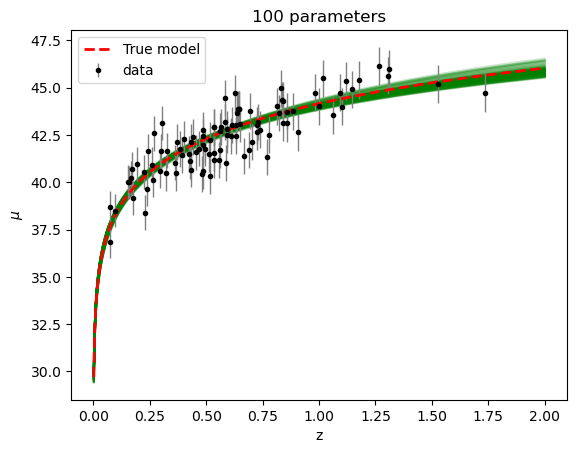

In [13]:
# Plot the 100 parameters samples
z_grid = np.linspace(0,2, 1000)

for i in np.random.randint(0, len(samples[:,1]), 100):

    plt.plot(z_grid, Cosmo_model(z_grid, samples[i, 1], samples[i, 0]), alpha = 0.2, c = 'g')
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z_grid, Cosmo_model(z_grid, 0.27, cosmo.H(0).value), label = 'True model', color = 'red', lw = 2, ls = '--')

plt.xlabel('z')
plt.ylabel('$\mu$')
plt.title('100 parameters')
plt.legend()
plt.show()


## Nested sampling 

I try also with a nested sampling algorithm that can be usefull to test different models

In [14]:
def transform_prior (u):
    
    x = np.copy(u)
    
    x[1] = (Omega_max - Omega_min) * u[1] + Omega_min
    x[0] = (Ho_max - Ho_min) * u[0] + Ho_min

    return x

1152it [00:01, 838.38it/s, +500 | bound: 0 | nc: 1 | ncall: 5533 | eff(%): 32.823 | loglstar:   -inf < -46.385 <    inf | logz: -47.823 +/-    nan | dlogz:  0.001 >  0.509]


Summary
nlive: 500
niter: 1152
ncall: 5033
eff(%): 32.823
logz: -47.823 +/-  0.087


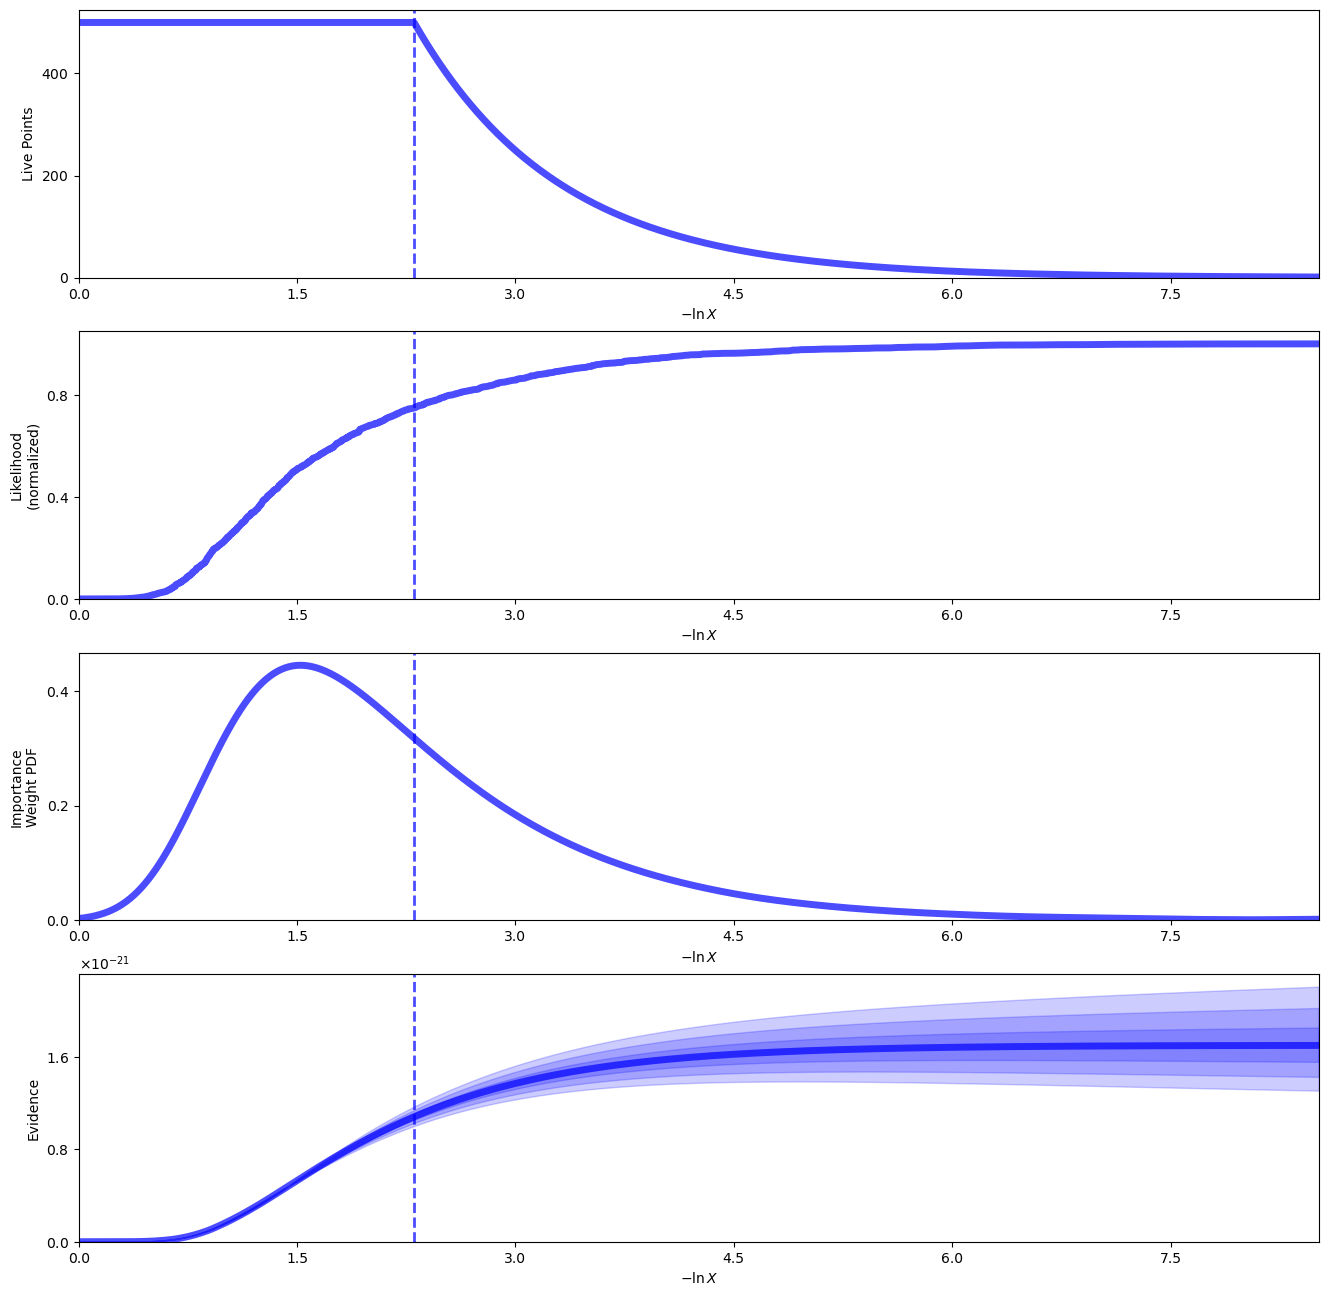

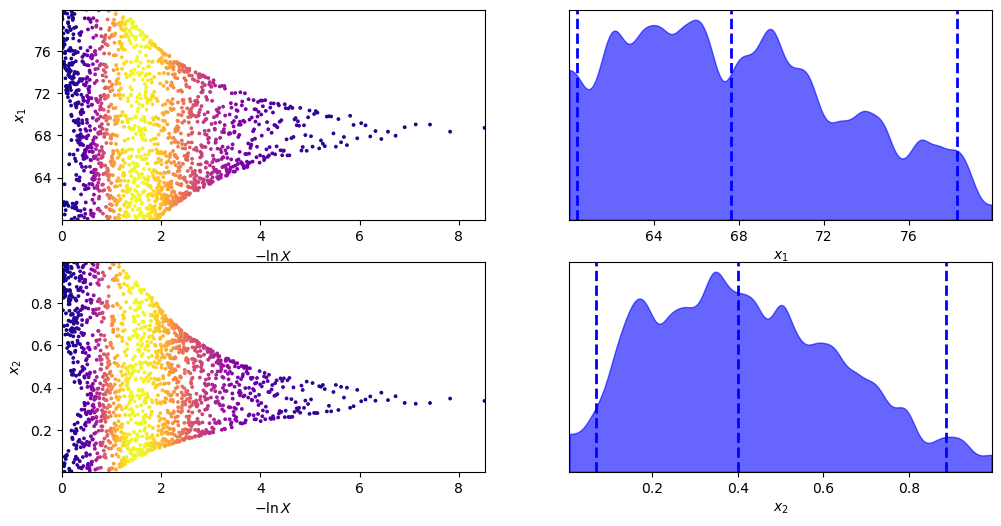

In [15]:
ndim = 2 

# nested sampling for the transient model with the exponential drop 
N_sampler = dynesty.NestedSampler(loglikelihood, transform_prior, ndim, logl_args = [z_sample, mu_sample, dmu])
N_sampler.run_nested(print_progress = True)

sresults_1 = N_sampler.results
weights = sresults_1.importance_weights()
sresults_1.summary()
N_samples = sresults_1.samples

# Peculiar plots format for the nested sampling results: they are weighted, 
# they need to be plotted properly with dynasty fucntions.
# They are mostly diagnostic plots: -lnX is the log of the prior volume:
# from left to right I'm climbing the likelihood and redcucing the prior volume

rfig, raxes = dyplot.runplot(sresults_1)
tfig, taxes = dyplot.traceplot(sresults_1)

In [16]:
means, covs = dyfunc.mean_and_cov(N_samples, weights)
print('Ho posterior mean: %.02f' %means[0])  #'Error: %.02f' %np.sqrt(covs[0,0]))
print('Omega_M' + 'posterior mean: %.02f' %means[1])  # 'Error: %.02f' %np.sqrt(covs[1,1]))

Ho posterior mean: 68.06
Omega_Mposterior mean: 0.42


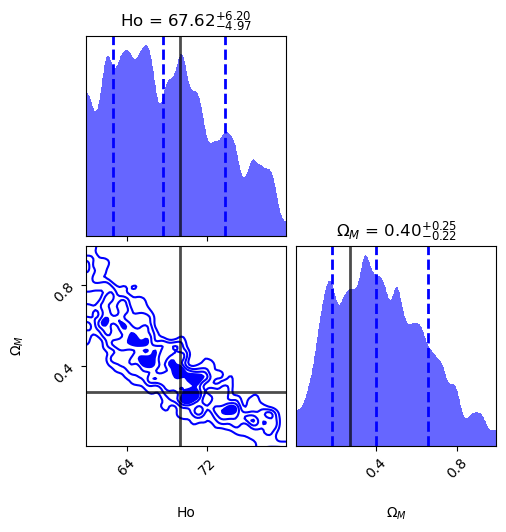

In [17]:
# dynesty corner plot
# Black is the true value

fig = plt.figure 
fg = dyplot.cornerplot(sresults_1, color = 'blue',
                           show_titles = True,
                           max_n_ticks = 2,
                           truths = np.array([cosmo.H(0).value, 0.27]),
                           truth_color = 'black',
                           quantiles = (0.16, 0.5, 0.84),
                           title_quantiles = (0.16, 0.5, 0.84),
                           labels = labels)
 

From the nested sampling, I can extract the log likelihood of each sample and then find the maximum

In [18]:
log_likelihood_nest = sresults_1.logl

max_nest_index = np.argmax(log_likelihood_nest)
max_likelihood_nest = N_samples[max_nest_index]

print('Best Ho: %.02f' %max_likelihood_nest[0])
print('Best Omega_M: %.02f' %max_likelihood_nest[1])

Best Ho: 68.71
Best Omega_M: 0.34


## Alternative model

I can try with an alternative universe model from cosmology, maybe the one with: $ \Omega_{\Lambda} = 0 $

In [19]:
Ho_lowlim = 10
Ho_uplim = 80    
    
def transform_prior_Ho (u):
    
    x = np.copy(u)
    x[0] = (Ho_uplim - Ho_lowlim) * u[0] + Ho_lowlim

    return x

def loglikelihood_Ho (param, z, mu, sigma_mu):
         
        Ho = float(param[0])
        Omega_mo = 1
        
        # Here I'm trying with the Astropy implementation:
        log_L_i = (mu - Cosmo_model(z, Omega_mo, Ho))**2 / (sigma_mu**2)
        return -0.5 * np.sum(log_L_i) 


1588it [00:03, 482.61it/s, +500 | bound: 0 | nc: 1 | ncall: 13672 | eff(%): 15.852 | loglstar:   -inf < -47.102 <    inf | logz: -49.373 +/-  0.037 | dlogz:  0.001 >  0.509]


Summary
nlive: 500
niter: 1588
ncall: 13172
eff(%): 15.852
logz: -49.373 +/-  0.114


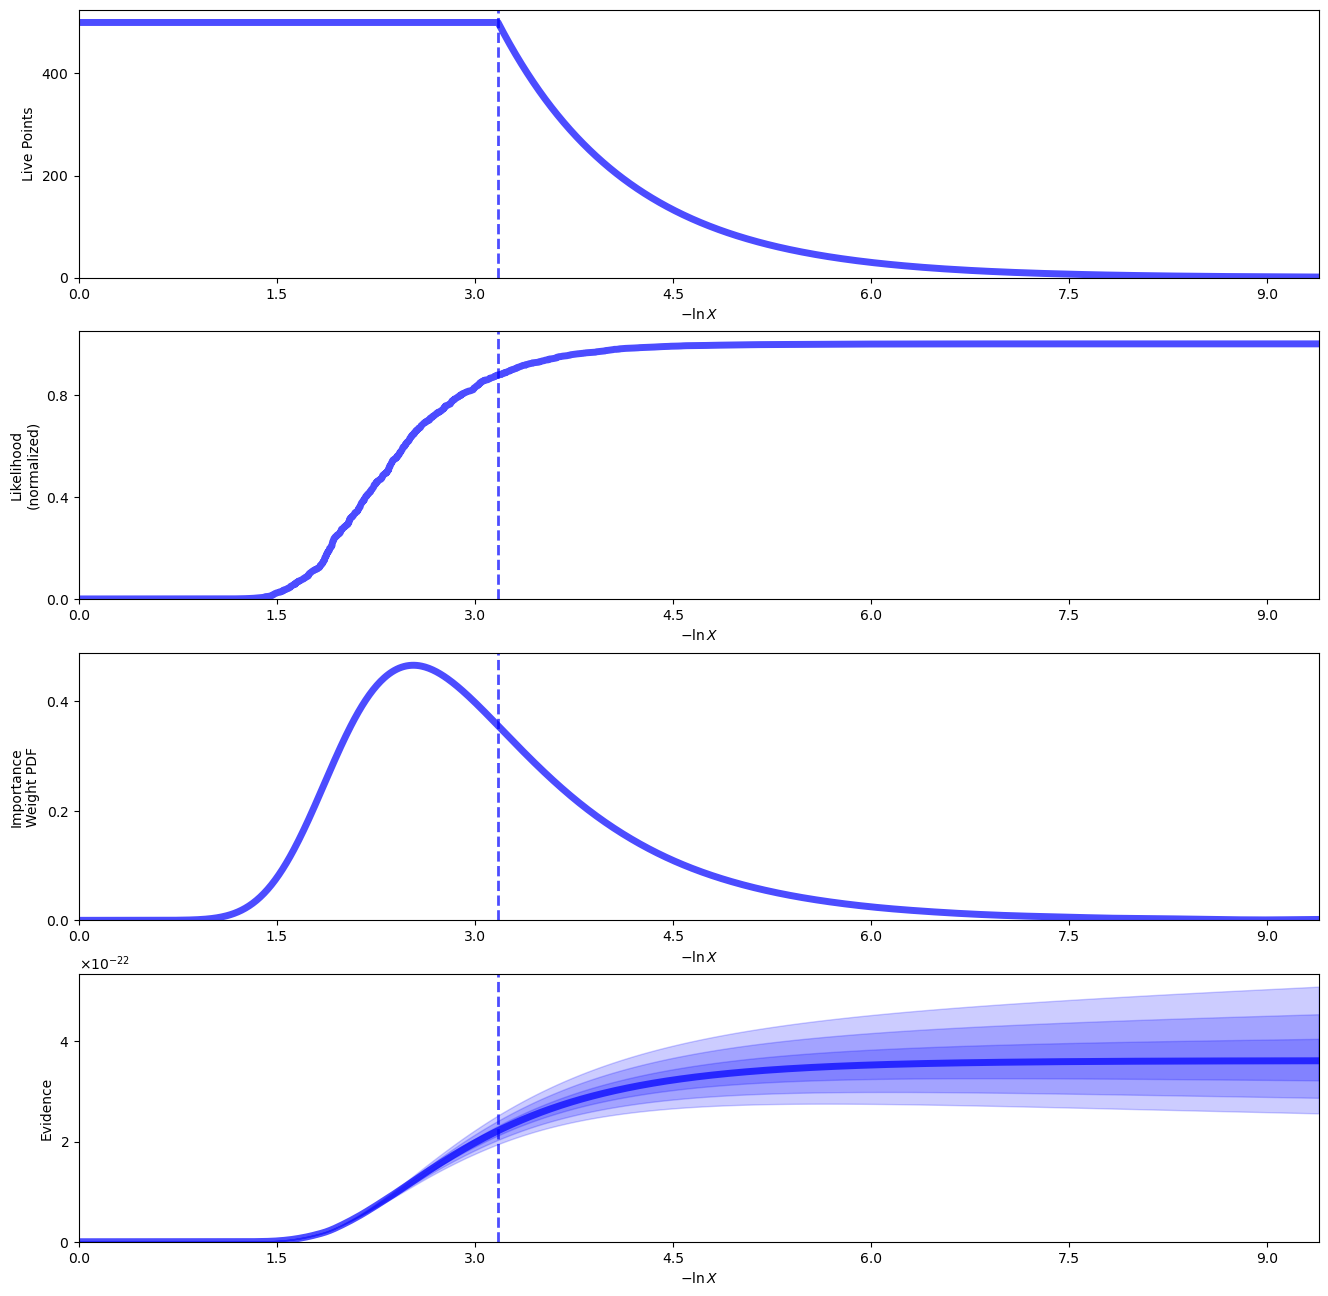

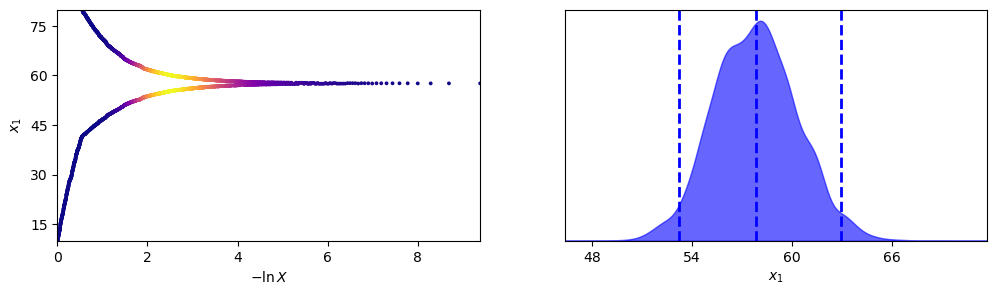

In [20]:
ndim = 1 

# nested sampling for the transient model with the exponential drop 
N2_sampler = dynesty.NestedSampler(loglikelihood_Ho, transform_prior_Ho, ndim, logl_args = [z_sample, mu_sample, dmu])
N2_sampler.run_nested(print_progress = True)

sresults_2 = N2_sampler.results
weights_2 = sresults_2.importance_weights()
sresults_2.summary()
samples_2 = sresults_2.samples

rfig, raxes = dyplot.runplot(sresults_2)
tfig, taxes = dyplot.traceplot(sresults_2)

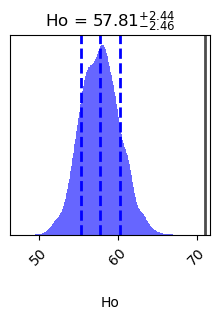

In [21]:
fig = plt.figure 
fg = dyplot.cornerplot(sresults_2, color = 'blue',
                           show_titles = True,
                           max_n_ticks = 1,
                           truths = np.array([71]),
                           truth_color = 'black',
                           quantiles = (0.16, 0.5, 0.84),
                           title_quantiles = (0.16, 0.5, 0.84),
                           labels = labels)
 

In [22]:
means_2, covs_2 = dyfunc.mean_and_cov(samples_2, weights_2)
print('Ho posterior mean: %.02f' %means_2[0])

Ho posterior mean: 57.80


In [23]:
log_likelihood_nest_2 = sresults_2.logl

max_nest_index_2 = np.argmax(log_likelihood_nest_2)
max_likelihood_nest_2 = samples_2[max_nest_index_2]

print('Best Ho: %.02f' %max_likelihood_nest_2[0])

Best Ho: 57.61


## Evidences

Let's compare the evidences out of the two nested samplings

In [24]:
Lambda_evidence = np.exp(sresults_1['logz'][-1])
#Lambda_evidence_err = np.exp(sresults_1['logzerr'][-1])

Ho_evidence = np.exp(sresults_2['logz'][-1])
#Ho_evidence_err = np.exp(sresults_2['logzerr'][-1])

print('Lambda-CDM cosmology model evidence: ', Lambda_evidence)
print('Lambda-CDM cosmology model evidence: ', Ho_evidence)

print('Logaritmic Bayes factor: %.02f' %np.log(Lambda_evidence/Ho_evidence))

Lambda-CDM cosmology model evidence:  1.701358354876178e-21
Lambda-CDM cosmology model evidence:  3.6122221586803903e-22
Logaritmic Bayes factor: 1.55


The bayes factor is $\textbf{substantial}$ in favor of the Lambda - CDM model 